In [49]:
# imports and loading
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import numpy as np
import os
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import sys
sys.path.insert(0, '../functions/')
import interface_GAMS as iG
import conversion_equations as ce
import pickle
import os
from matplotlib.colors import Normalize
import ast
import seaborn as sns
import itertools as it
from pymodulon.io import load_json_model
from sklearn.metrics import r2_score

# load in a bunch of potentially useful files
# loading merged log_tpm_file
# merge together log_tpm_df files
log_tpm_df = pd.read_csv('../data/precise_1k/log_tpm.csv', index_col = 0)
starve_log_tpm = pd.read_csv('../data/validation_data_sets/stationary_phase/cleaned_log_tpm_qc.csv', index_col = 0)
to_blank_inds = list(set(log_tpm_df.index) - set(starve_log_tpm.index))
# need to create zero rows for missing values
zeros_data = {col : 0 for col in starve_log_tpm.columns}
zeros_df = pd.DataFrame(zeros_data, index = to_blank_inds)
starve_log_tpm = pd.concat([starve_log_tpm, zeros_df])
starve_log_tpm = starve_log_tpm.loc[log_tpm_df.index]
log_tpm_df = pd.concat([starve_log_tpm, log_tpm_df], axis = 1)

starve_metabs = pd.read_excel('../data/validation_data_sets/stationary_phase/metabolites_data.xlsx', index_col = 0)

pickle_in = open('../data/b_to_gene.pkl', 'rb')
b_to_gene = pickle.load(pickle_in)
pickle_in.close()
gene_to_b = {v : k for k, v in b_to_gene.items()}

flags_df = pd.read_csv('../data/saved_flags_expanded_curated.csv', index_col = 0)
flags_df = flags_df[flags_df['include']]

TF_flags_df = pd.read_csv('../data/TF_flags_expanded.csv', index_col = 0)

iM_table = pd.read_csv('../data/precise_1k/iM_table.csv', index_col = 0)
k_to_iM = {str(index) : row['name'] for index, row in iM_table.iterrows()}
M_df = pd.read_csv('../data/precise_1k/M.csv', index_col = 0).rename(columns = k_to_iM)
A_df = pd.read_csv('../data/precise_1k/A.csv', index_col = 0).rename(index = {int(k) : v for k, v in k_to_iM.items()})

TRN_df = pd.read_pickle('../data/regulonDB_files/TRN_df.pkl')
p1k = load_json_model('../data/precise_1k/precise1k.json')

In [50]:
# first we need to make a ratio df
if False: # change to True to run again
    cases = set([(row['act_iM'], row['inh_iM']) for _, row in flags_df.iterrows()])
    collect_actuals = []
    collect_predictions = []
    for iMs_run in cases:
        clean = [x for x in iMs_run if str(x) != 'nan']
        case = '___'.join([str(iM) for iM in iMs_run]).replace(' ', '_').replace('/', '_')
        if not os.path.exists('../GAMs/optimization_runs/'+case):
            continue

        # let's find our run_dir
        try:
            iter_f = 'iter_'+str(max([int(f.split('_')[1]) for f in os.listdir('../GAMs/optimization_runs/'+case) if 'iter_' in f and '.pkl' not in f]))
            run_f = 'run_'+str(max([int(f.split('_')[1]) for f in os.listdir('../GAMs/optimization_runs/'+case+'/'+iter_f) if 'run_' in f and '.pkl' not in f]))
            GAMs_run_dir = '../GAMs/optimization_runs/'+case+'/'+iter_f+'/'+run_f
            mRNA_df, GAMS_calc_cAct, cAct_kd_df, act_metab_df, act_kd_metab_df, GAMS_calc_cInh, cInh_kd_df, inh_metab_df, inh_kd_metab_df = iG.read_multi_GAMs(GAMs_run_dir)
        except:
            continue # Usually means it hasn't been run yet
        actual_ratio = ce.log_tpm_df_to_mRNA_ratio_df(log_tpm_df.loc[mRNA_df.columns], flags_df.loc[mRNA_df.columns])

        collect_actuals.append(actual_ratio)
        collect_predictions.append(mRNA_df)

    merge_actual = pd.concat(collect_actuals, axis = 1)
    merge_pred = pd.concat(collect_predictions, axis = 1)
    overlap = list(set(merge_actual.index).intersection(set(merge_pred.index)))
    actual_mRNA_df = merge_actual.loc[:,~merge_actual.columns.duplicated()].astype(float)
    pred_mRNA_df = merge_pred.loc[:,~merge_pred.columns.duplicated()].astype(float)

    # create sample-sample and gene-gene correlation dataframe
    sample_corr_df = pd.DataFrame(index = actual_mRNA_df.index, columns = actual_mRNA_df.index)
    for sample1 in actual_mRNA_df.index:
        for sample2 in actual_mRNA_df.index:
            sample_corr_df.at[sample1, sample2] = actual_mRNA_df.loc[sample1].corr(pred_mRNA_df.loc[sample2])
    gene_corr_df = pd.DataFrame(index = actual_mRNA_df.columns, columns = actual_mRNA_df.columns)
    for sample1 in actual_mRNA_df.columns:
        for sample2 in actual_mRNA_df.columns:
            gene_corr_df.at[sample1, sample2] = actual_mRNA_df[sample1].corr(pred_mRNA_df[sample2])

    # these things take a while to run, let's save them off
    sample_corr_df.to_csv('../data/samples_correlation_df.csv')
    gene_corr_df.to_csv('../data/genes_correlation_df.csv')
else:
    # load in
    sample_corr_df = pd.read_csv('../data/samples_correlation_df.csv', index_col = 0)
    gene_corr_df = pd.read_csv('../data/genes_correlation_df.csv', index_col = 0)

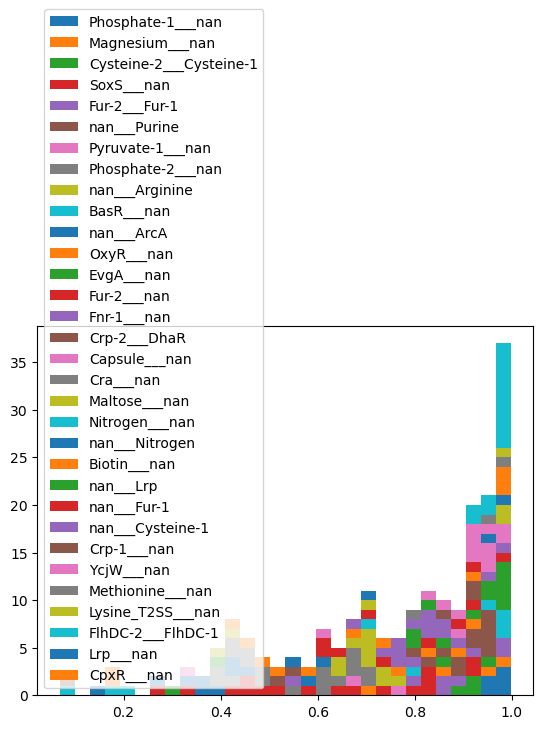

In [10]:
# stacked histogram - try rerunning once all samples run

case_to_genes = {}
case_to_avr_corr = {}
plot_vals = []
plot_labels = []
for iMs_run in set([(row['act_iM'], row['inh_iM']) for _, row in flags_df.iterrows()]):
    clean = [x for x in iMs_run if str(x) != 'nan']
    case = '___'.join([str(iM) for iM in iMs_run]).replace(' ', '_').replace('/', '_')
    # let's find our run_dir
    try:
        iter_f = 'iter_'+str(max([int(f.split('_')[1]) for f in os.listdir('../GAMs/optimization_runs/'+case) if 'iter_' in f and '.pkl' not in f]))
        run_f = 'run_'+str(max([int(f.split('_')[1]) for f in os.listdir('../GAMs/optimization_runs/'+case+'/'+iter_f) if 'run_' in f and '.pkl' not in f]))
        GAMs_run_dir = '../GAMs/optimization_runs/'+case+'/'+iter_f+'/'+run_f
        mRNA_df, GAMS_calc_cAct, cAct_kd_df, act_metab_df, act_kd_metab_df, GAMS_calc_cInh, cInh_kd_df, inh_metab_df, inh_kd_metab_df = iG.read_multi_GAMs(GAMs_run_dir)
    except:
        continue # Usually means it hasn't been run yet
    plot_labels.append(case)
    plot_vals.append(np.diag(gene_corr_df.loc[mRNA_df.columns][mRNA_df.columns]))
    case_to_avr_corr.update({case : np.mean(np.diag(gene_corr_df.loc[mRNA_df.columns][mRNA_df.columns]))})
plt.hist(plot_vals, stacked = True, bins = 30, label = plot_labels)
plt.legend()
plt.show()

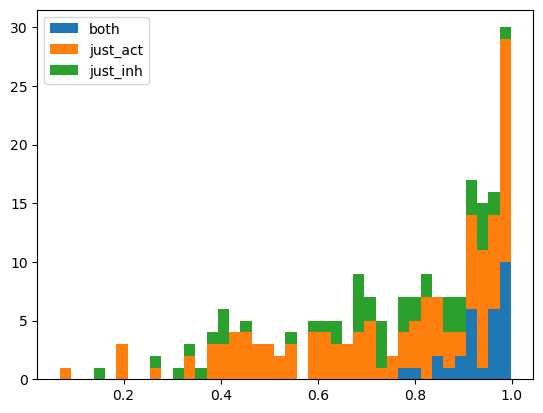

In [125]:
# same as above, but split by case type (dual regulator, all inhibitor, all activator)

type_to_cases = {
    'both' : [],
    'just_act' : [],
    'just_inh' : []
}
for iMs_run in set([(row['act_iM'], row['inh_iM']) for _, row in flags_df.iterrows()]):
    if str(iMs_run[0]) != 'nan' and str(iMs_run[1]) != 'nan':
        type_to_cases['both'].append(iMs_run)
    elif str(iMs_run[0]) != 'nan' and str(iMs_run[1]) == 'nan':
        type_to_cases['just_act'].append(iMs_run)
    elif str(iMs_run[0]) == 'nan' and str(iMs_run[1]) != 'nan':
        type_to_cases['just_inh'].append(iMs_run)
plot_vals = []
plot_labels = []
all_genes = set()
for type, cases in type_to_cases.items():
    plot_labels.append(type)
    temp_plot_vals = []
    for iMs_run in cases:
        case = '___'.join([str(iM) for iM in iMs_run]).replace(' ', '_').replace('/', '_')
        # let's find our run_dir
        try:
            iter_f = 'iter_'+str(max([int(f.split('_')[1]) for f in os.listdir('../GAMs/optimization_runs/'+case) if 'iter_' in f and '.pkl' not in f]))
            run_f = 'run_'+str(max([int(f.split('_')[1]) for f in os.listdir('../GAMs/optimization_runs/'+case+'/'+iter_f) if 'run_' in f and '.pkl' not in f]))
            GAMs_run_dir = '../GAMs/optimization_runs/'+case+'/'+iter_f+'/'+run_f
            mRNA_df, GAMS_calc_cAct, cAct_kd_df, act_metab_df, act_kd_metab_df, GAMS_calc_cInh, cInh_kd_df, inh_metab_df, inh_kd_metab_df = iG.read_multi_GAMs(GAMs_run_dir)
        except:
            continue # Usually means it hasn't been run yet
        for val in np.diag(gene_corr_df.loc[mRNA_df.columns][mRNA_df.columns]):
            temp_plot_vals.append(val)
        for gene in mRNA_df.columns:
            all_genes.add(gene)
    plot_vals.append(temp_plot_vals)

plt.hist(plot_vals, stacked = True, bins = 40, label = plot_labels)
plt.legend()
plt.savefig('../figures/gene_pred_corrs_histogram.pdf', transparent = True)
plt.show()

In [124]:
mRNA_df

,b3959,b2818,b2306,b3957,b3359,b2307,b3960,b3172,b2308,b3958
p1k_00391,0.056795,0.057639,0.325554,0.063871,0.159461,0.213828,0.054283,0.001372,0.131313,0.051472
p1k_00157,0.05237,0.053151,0.307003,0.058929,0.148293,0.199758,0.050043,0.001259,0.121831,0.047441
p1k_00362,0.019752,0.020057,0.139067,0.022323,0.059696,0.083424,0.018846,0.00046,0.048149,0.017836
p1k_00816,0.086996,0.088246,0.433053,0.097447,0.230891,0.300894,0.083266,0.00217,0.19303,0.079081
p1k_00132,0.126418,0.128155,0.537047,0.140873,0.313152,0.395277,0.121221,0.003291,0.266476,0.115368
...,...,...,...,...,...,...,...,...,...,...
p1k_00297,0.07798,0.079112,0.404045,0.087452,0.210399,0.276421,0.074605,0.001926,0.175133,0.070821
p1k_00001,0.096519,0.097891,0.461316,0.107978,0.25182,0.325482,0.092421,0.002432,0.21147,0.08782
p1k_00613,0.086596,0.087841,0.431815,0.097004,0.229996,0.299834,0.082882,0.002159,0.192245,0.078714
p1k_00179,0.060618,0.061515,0.340929,0.068137,0.168957,0.225692,0.057947,0.00147,0.139411,0.054958


In [70]:
TRN_df

,b4237,b0579,b2460,b3319,b0431,b0889,b1136,b1485,b3905,b1434,...,b1037,b4025,b2406,b2607,b1886,b3120,b4318,b2297,b0032,b2840
b4237,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
b0579,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
b2460,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
b3319,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
b0431,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b3120,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
b4318,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
b2297,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
b0032,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [120]:
log_tpm_df

,starve_series__t00_growth1,starve_series__t01_starve,starve_series__t02_starve,starve_series__t03_starve,starve_series__t04_starve,starve_series__t05_starve,starve_series__t06_starve,starve_series__t07_starve,starve_series__t08_starve,starve_series__t09_starve,...,p1k_01046,p1k_01047,p1k_01048,p1k_01049,p1k_01050,p1k_01051,p1k_01052,p1k_01053,p1k_01054,p1k_01055
b0001,7.525250,5.244353,4.705850,5.249964,4.946542,5.592930,5.953264,6.030049,4.923034,6.407492,...,9.600793,9.234737,9.607747,9.894369,9.839448,9.892174,9.988233,9.488565,9.221845,10.170968
b0002,9.976135,7.922554,4.927676,4.301199,4.265368,3.908641,4.122708,3.812092,3.769725,3.716079,...,9.446533,8.302502,8.452109,8.363976,8.672402,8.647693,9.675175,8.761815,8.421964,8.483203
b0003,10.268073,9.384985,8.315080,8.490838,8.418734,8.536812,8.539255,8.346285,8.331133,8.232331,...,8.480662,7.449754,7.467061,7.538769,7.723832,7.670143,8.857956,7.922229,7.633727,7.859478
b0004,10.064425,8.956723,8.307074,8.466064,8.511251,8.453452,8.253001,7.968510,7.960604,7.840496,...,9.282031,8.281564,8.364711,8.249902,8.597246,8.722178,9.444481,8.395833,8.590145,8.446588
b0005,6.290788,4.667634,4.131256,3.825022,3.767603,3.455313,3.567048,3.434167,3.621247,3.973991,...,4.206849,2.505517,3.065065,4.168111,4.056920,4.030515,4.921936,3.311463,2.568554,4.185822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b4753,0.000000,0.000000,0.000000,0.000000,0.000000,0.904086,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.646312,1.965895,0.000000
b4754,1.155669,0.000000,2.186083,2.173615,1.953790,2.957169,2.400392,2.419995,0.000000,1.352355,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.194440
b4755,0.000000,0.000000,0.501101,0.000000,0.000000,0.000000,0.494767,1.030513,0.580627,0.000000,...,1.766240,2.360501,2.262935,3.134435,4.098685,0.000000,0.000000,5.813532,4.314107,3.964110
b4756,4.401973,4.745988,3.826966,4.526702,4.524921,3.429839,3.502482,3.523325,3.560417,4.405355,...,4.102627,4.008173,2.070294,4.368630,4.418069,0.000000,3.142907,3.594040,3.586631,5.103798


In [109]:
no_regs = set(log_tpm_df.index) - set(TRN_df.columns)
for val in TRN_df.columns[abs(TRN_df).sum() == 0]:
    for va in val.split(','):
        no_regs.add(va)
no_regs = list(no_regs)

In [113]:
low_var = log_tpm_df.loc[log_tpm_df.var(axis = 1).sort_values() < 1].var(axis = 1).index.to_list()

In [132]:
good_genes = set(log_tpm_df.index) - set(no_regs) - set(low_var)

In [116]:
no_regs_not_in_low_var = set(no_regs) - set(low_var)

In [118]:
len(no_regs_not_in_low_var)

732

In [123]:
1997 - 732

1265

In [138]:
len(good_genes) - 138

1127

In [136]:
a = all_genes.intersection(good_genes)

In [137]:
len(a)

138

In [12]:
# what's wrong with the terrible ones?
worst_cases = [k for k, _ in sorted(case_to_avr_corr.items(), key = lambda k : k[1])]
for case in worst_cases:
    print(case+' : '+str(case_to_avr_corr[case]))

Nitrogen___nan : 0.12929490740720842
nan___ArcA : 0.3790272509510826
Cra___nan : 0.42868342780781904
CpxR___nan : 0.4491178961228379
Crp-1___nan : 0.49610951150619564
Lrp___nan : 0.5501807712919035
Phosphate-2___nan : 0.6106698113232795
SoxS___nan : 0.6308391128167734
nan___Lrp : 0.6604782939357429
Lysine_T2SS___nan : 0.6992977989034799
nan___Arginine : 0.6996670640649844
Pyruvate-1___nan : 0.720689943202802
nan___Cysteine-1 : 0.7497691184063794
Fur-2___nan : 0.7593307063830147
nan___Fur-1 : 0.7642023453491766
Maltose___nan : 0.8021995566612917
BasR___nan : 0.8049461496000749
OxyR___nan : 0.8161308930144684
YcjW___nan : 0.8186791551413556
Fnr-1___nan : 0.8442662191803404
Crp-2___DhaR : 0.871905886584465
Magnesium___nan : 0.886222046121354
Fur-2___Fur-1 : 0.8988747576595613
Methionine___nan : 0.9133826523512698
nan___Purine : 0.9170526774899397
Cysteine-2___Cysteine-1 : 0.9210726269382421
Capsule___nan : 0.9498165379416169
EvgA___nan : 0.9561400889010359
Biotin___nan : 0.963220425695269

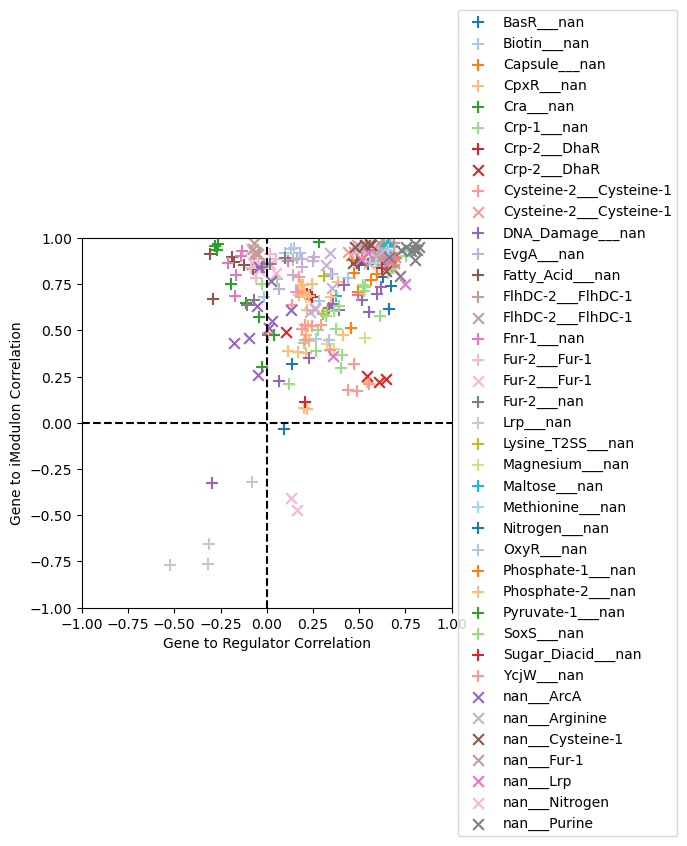

In [13]:
# correlation between gene and regulator, gene and iModulon
# settings
colors = list(cm.tab20.colors)
markers = ['o', 'x']


gene_reg_corrs = []
gene_iM_corrs = []
act_or_inhs = []
labels = []
cases = []
for iMs_run in set([(str(row['act_iM']), str(row['inh_iM'])) for _, row in flags_df.iterrows()]):
    clean = [x for x in iMs_run if str(x) != 'nan']
    case = '___'.join([str(iM) for iM in iMs_run]).replace(' ', '_').replace('/', '_')
    
    # limit down
    keep = []
    for index, row in flags_df.iterrows():
        if str(row['act_iM']) == iMs_run[0] and str(row['inh_iM']) == iMs_run[1]:
            keep.append(index)
    bby_flags = flags_df.loc[keep]
    dual_case = False
    if iMs_run[0] != 'nan' and iMs_run[1] != 'nan':
        dual_case = True
    elif iMs_run[0] == 'nan':
        iM_use = iMs_run[1].replace('_', '/')
        act_or_inh = 'inh'
    elif iMs_run[1] == 'nan':
        iM_use = iMs_run[0].replace('_', '/')
        act_or_inh = 'act'
    to_add = TF_flags_df.loc[iM_use].gene_name

    # generate values
    if not dual_case:
        for key, val in log_tpm_df.loc[bby_flags.index.to_list()+[to_add]].T.corr()[to_add].items():
            if key != to_add:
                gene_reg_corrs.append(val)
        overlap = list(set(A_df.columns.intersection(log_tpm_df.columns)))
        for gene in bby_flags.index:
            corr = np.corrcoef(log_tpm_df.loc[gene][overlap], A_df.loc[iM_use][overlap])[0, 1]
            gene_iM_corrs.append(corr)
            labels.append(gene)
            cases.append(case)
            act_or_inhs.append(act_or_inh)
    else:
        for iM, act_or_inh in zip(iMs_run, ['act', 'inh']):
            iM_use = iM.replace('_', '/')
            to_add = TF_flags_df.loc[iM_use].gene_name
            for key, val in log_tpm_df.loc[bby_flags.index.to_list()+[to_add]].T.corr()[to_add].items():
                if key != to_add:
                    gene_reg_corrs.append(val)
            overlap = list(set(A_df.columns.intersection(log_tpm_df.columns)))
            for gene in bby_flags.index:
                corr = np.corrcoef(log_tpm_df.loc[gene][overlap], A_df.loc[iM_use][overlap])[0, 1]
                gene_iM_corrs.append(corr)
                labels.append(gene)
                cases.append(case)
                act_or_inhs.append(act_or_inh)

corrs_df = pd.DataFrame(index = labels)
corrs_df['gene_reg_corrs'] = gene_reg_corrs
corrs_df['gene_iM_corrs'] = gene_iM_corrs
corrs_df['cases'] = cases
corrs_df['act_or_inhs'] = act_or_inhs

case_to_marker = {
    'act' : '+',
    'inh' : 'x',
}
iM_to_color = {}
mark_col = it.product(markers, colors)
for case, df in corrs_df.groupby('cases'):
    mark, col = next(mark_col)
    iM_to_color.update({case : col})
    for case2, df2 in df.groupby('act_or_inhs'):
        marker = case_to_marker[case2]
        if marker == '+':
            size = 80
        else:
            size = 60
        plt.scatter(df2['gene_reg_corrs'], df2['gene_iM_corrs'], s = size, label = case, color = col, marker = marker)
plt.xlabel('Gene to Regulator Correlation')
plt.ylabel('Gene to iModulon Correlation')
plt.axvline(x = 0, ls = '--', c = 'k')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axhline(y = 0, ls = '--', c = 'k')
plt.axis('square')
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.savefig('../figures/gene_iM_corrs.pdf', transparent = True)
plt.show()

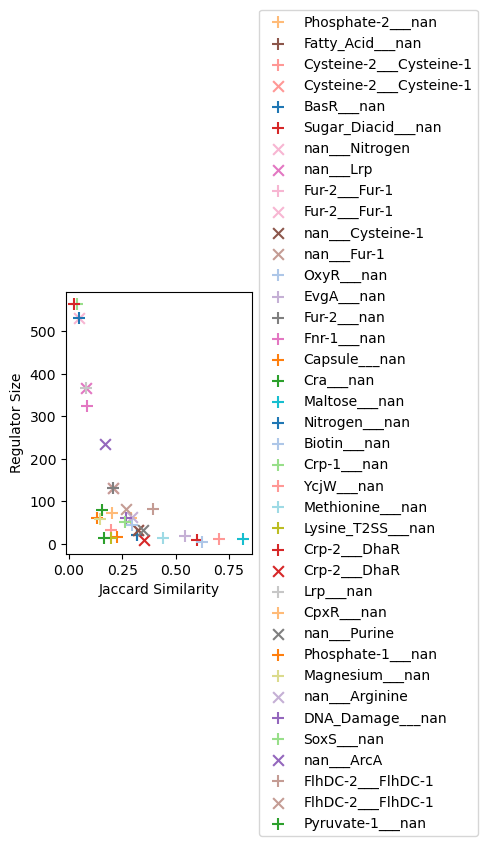

In [14]:
# also iM genes, regulon overlap
#p1k = load_json_model('../data/precise_1k/precise1k.json')
#TRN_df = TRN_df = pd.read_pickle('../data/regulonDB_files/TRN_df.pkl')

p1k.view_imodulon('Arginine').columns


# correlation between gene and regulator, gene and iModulon
# settings
colors = list(cm.tab20.colors)
markers = ['o', 'x']


jaccard_sims = []
reg_size = []
act_or_inhs = []
cases = []
for iMs_run in set([(str(row['act_iM']), str(row['inh_iM'])) for _, row in flags_df.iterrows()]):
    clean = [x for x in iMs_run if str(x) != 'nan']
    case = '___'.join([str(iM) for iM in iMs_run]).replace(' ', '_').replace('/', '_')
    
    # limit down
    keep = []
    for index, row in flags_df.iterrows():
        if str(row['act_iM']) == iMs_run[0] and str(row['inh_iM']) == iMs_run[1]:
            keep.append(index)
    bby_flags = flags_df.loc[keep]
    dual_case = False
    if iMs_run[0] != 'nan' and iMs_run[1] != 'nan':
        dual_case = True
    elif iMs_run[0] == 'nan':
        iM_use = iMs_run[1].replace('_', '/')
        act_or_inh = 'inh'
    elif iMs_run[1] == 'nan':
        iM_use = iMs_run[0].replace('_', '/')
        act_or_inh = 'act'
    to_add = TF_flags_df.loc[iM_use].gene_name
    
    
    # generate values
    if not dual_case:
        iM_genes = set(p1k.view_imodulon(iM_use).index.to_list())
        regulon = set(TRN_df.columns[TRN_df.loc[to_add] != 0].to_list())
        jaccard_sims.append(len(iM_genes.intersection(regulon)) / len(iM_genes.union(regulon)))
        act_or_inhs.append(act_or_inh)
        cases.append(case)
        reg_size.append(len(regulon))
    else:
        for iM, act_or_inh in zip(iMs_run, ['act', 'inh']):
            iM_use = iM.replace('_', '/')
            to_add = TF_flags_df.loc[iM_use].gene_name
            iM_genes = set(p1k.view_imodulon(iM_use).index.to_list())
            regulon = set(TRN_df.columns[TRN_df.loc[to_add] != 0].to_list())
            jaccard_sims.append(len(iM_genes.intersection(regulon)) / len(iM_genes.union(regulon)))
            act_or_inhs.append(act_or_inh)
            cases.append(case)
            reg_size.append(len(regulon))
jacc_df = pd.DataFrame(index = cases)
jacc_df['jaccard_sims'] = jaccard_sims
jacc_df['reg_size'] = reg_size
jacc_df['act_or_inhs'] = act_or_inhs


case_to_marker = {
    'act' : '+',
    'inh' : 'x',
}
plt.figure(figsize = (12/5, 17/5))
for index, row in jacc_df.iterrows():
    color = iM_to_color[index]
    marker = case_to_marker[row['act_or_inhs']]
    if marker == '+':
        size = 80
    else:
        size = 60
    plt.scatter(row['jaccard_sims'], row['reg_size'], s = size, label = index, color = color, marker = marker)
plt.xlabel('Jaccard Similarity')
plt.ylabel('Regulator Size')
#plt.axvline(x = 0, ls = '--', c = 'k')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.axhline(y = 0, ls = '--', c = 'k')
#plt.axis('square')
#plt.xlim([-1, 1])
#plt.ylim([-1, 1])
plt.savefig('../figures/jaccard_scores.pdf', transparent = True)
plt.show()

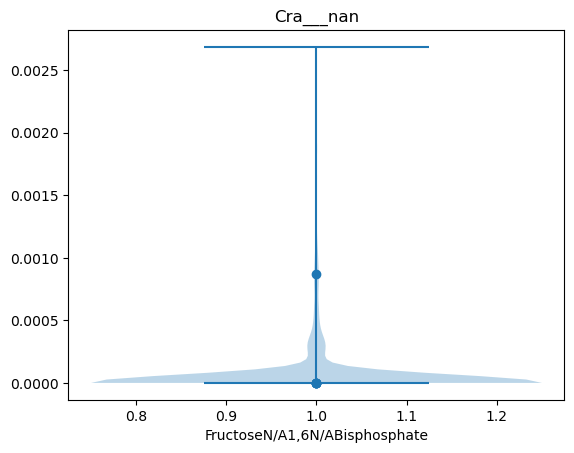

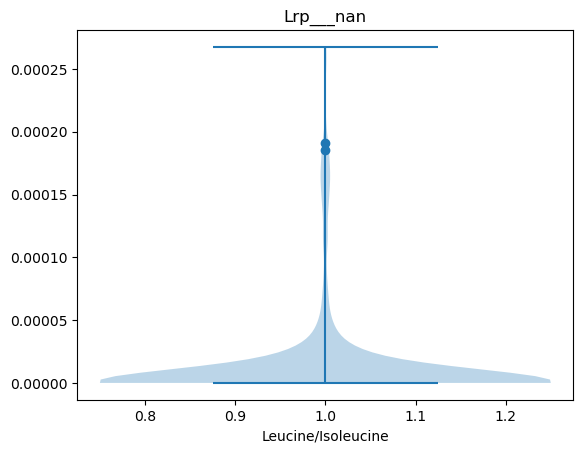

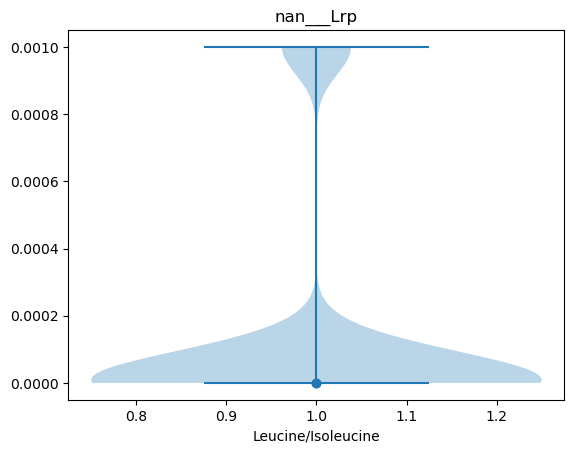

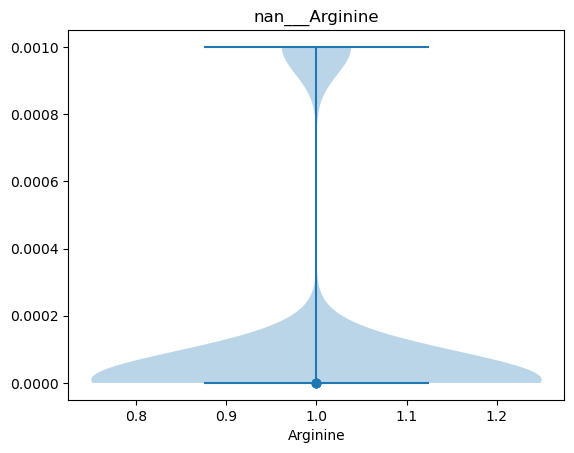

In [15]:
# I want to check out the specific examples where metabolite concentrations can be compared to P1K_metadata
p1k_effectors_to_samples = {
    'FructoseN/A1,6N/ABisphosphate' : ['p1k_00084', 'p1k_00085', 'p1k_00088', 'p1k_00089', 
        'p1k_00105', 'p1k_00116', 'p1k_00117', 'p1k_00118'],
    'Leucine/Isoleucine' : ['p1k_00171', 'p1k_00172'],
    'Arginine' : ['p1k_00165', 'p1k_00166', 'p1k_00277', 'p1k_00278'],
    'Phosphoenolpyruvate' : ['p1k_00062', 'p1k_00063', 'p1k_00183', 'p1k_00184', 'p1k_00279', 
        'p1k_00280', 'p1k_00463', 'p1k_00464', 'p1k_00507', 'p1k_00508'],
}
effector_to_cases = {
    'FructoseN/A1,6N/ABisphosphate' : ['Cra___nan'],
    'Leucine/Isoleucine' : ['Lrp___nan', 'nan___Lrp'],
    'Arginine' : ['nan___Arginine'],
    'Phosphoenolpyruvate' : [],
}

for effector, samples in p1k_effectors_to_samples.items():
    # let's find the cases
    cases = effector_to_cases[effector]
    
    # loop through cases, make some type of highlighted violin plot?
    for case in cases:
        # load
        try:
            iter_f = 'iter_'+str(max([int(f.split('_')[1]) for f in os.listdir('../GAMs/optimization_runs/'+case) if 'iter_' in f and '.pkl' not in f]))
            run_f = 'run_'+str(max([int(f.split('_')[1]) for f in os.listdir('../GAMs/optimization_runs/'+case+'/'+iter_f) if 'run_' in f and '.pkl' not in f]))
            GAMs_run_dir = '../GAMs/optimization_runs/'+case+'/'+iter_f+'/'+run_f
            mRNA_df, GAMS_calc_cAct, cAct_kd_df, act_metab_df, act_kd_metab_df, GAMS_calc_cInh, cInh_kd_df, inh_metab_df, inh_kd_metab_df = iG.read_multi_GAMs(GAMs_run_dir)
        except:
            continue

        # ZZZ XXX TODO - finish this code, I couldn't because the optimization runs are on another fork and I do not feel like fixing that
        plt.violinplot(act_metab_df['Val'])
        overlap = list(set(samples).intersection(act_metab_df.index))
        plt.scatter(y = act_metab_df['Val'].loc[overlap], x = [1 for _ in range(len(overlap))])
        plt.title(case)
        plt.xlabel(effector)
        plt.show()

In [45]:
# loop through all TF conc predictors, compare to actual
act_iMs = TF_flags_df[TF_flags_df['cAct_no_effector_form'] == 1]
inh_iMs = TF_flags_df[TF_flags_df['cInh_no_effector_form'] == 1]

# start with activators
# first let's find all cases not iMs
for iM in act_iMs:
    cases = []
    for case in os.listdir('../GAMs/optimization_runs')

In [46]:
inh_cases

,TF,gene_name,effectors,filter_outliers_less_than_X_corr_to_rest,cAct_no_effector_form,cAct_multi_effector_binding,cAct_multi_co_effector_binding,cInh_no_effector_form,cInh_multi_effector_binding,cInh_multi_co_effector_binding,kd_inh_metab_up,kd_inh_metab_lo,kd_act_metab_up,kd_act_metab_lo
Sugar Diacid,cdaR,b0162,[],0.3,1,0,0,1,0,0,0.380789,4.800000e-08,0.380789,4.800000e-08
FlhDC-1,flhC,b1892,[],0.3,1,0,0,1,0,0,0.380789,4.800000e-08,0.380789,4.800000e-08
FlhDC-2,flhC,b1892,[],0.3,1,0,0,1,0,0,0.380789,4.800000e-08,0.380789,4.800000e-08
DNA Damage,lexA,b4043,[],0.3,1,0,0,1,0,0,0.380789,4.800000e-08,0.380789,4.800000e-08
Nitrogen,nac,b1988,[],0.3,1,0,0,1,0,0,0.380789,4.800000e-08,0.380789,4.800000e-08
Capsule,rcsA,b1951,[],0.3,1,0,0,1,0,0,0.380789,4.800000e-08,0.380789,4.800000e-08
SoxS,soxS,b4062,[],0.3,1,0,0,1,0,0,0.380789,4.800000e-08,0.380789,4.800000e-08
YcjW,ycjW,b1320,[],0.3,1,0,0,1,0,0,0.380789,4.800000e-08,0.380789,4.800000e-08
ArcA,arcA,b4401,['revisit'],0.3,1,0,0,1,0,0,0.380789,4.800000e-08,0.380789,4.800000e-08
Biotin,birA,b3973,['revisit'],0.3,1,0,0,1,0,0,0.380789,4.800000e-08,0.380789,4.800000e-08


In [47]:
cases

['Crp-2___DhaR']

In [41]:
iM

'kd_act_metab_lo'